# Toggle Time Tracking
markdown-pdf is needed for PDF Report: https://www.npmjs.com/package/markdown-pdf

```npm install -g markdown-pdf```

## Setup

### Import sub-modules

In [1]:
# Import required sub-modules

# watermark
import watermark

# Toggl Wrapper API 
# https://github.com/matthewdowney/TogglPy
import TogglPy
from base_functions import *

In [2]:
%load_ext watermark
%watermark -a "Silvan Zahno" -d -v -iv -m -h

re        2.2.1
pandas    1.0.2
numpy     1.18.1
watermark 2.0.2
IPython   7.13.0
pytz      2019.3
json      2.0.9
plotly    4.5.2
Silvan Zahno 2020-03-27 

CPython 3.7.6
IPython 7.13.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : zell


In [3]:
verbose = 2

### Configuration

In [4]:
# Setup local input directories
inputDir = "input" + os.sep
createDir(inputDir)

In [5]:
# Setup local input directories
outputDir = "output" + os.sep
md_subdir = "md" + os.sep
data_subdir = "data" + os.sep
graph_subdir = "graph" + os.sep
createDir(os.path.realpath(outputDir))
createDir(os.path.realpath(outputDir + md_subdir))
createDir(os.path.realpath(outputDir + data_subdir))
createDir(os.path.realpath(outputDir + md_subdir + graph_subdir))

In [6]:
# Graph output Options
class GraphOutputOption(enum.Enum):
    none = 'none'                     # Do not generate any plots
    inline = 'inline'                 # Generate inline plots only
    htmlFile = 'extFile'              # Generate plots in external files (html or png or ...)
    both = 'both'                     # Generate all plots inline and external
    
class GraphInteractionOption(enum.Enum):
    static = 'static'                 # Generate static inline plots (as images)
    interactive = 'interactive'       # Generate interactive inline plots

notebookGraphingInteraction = GraphInteractionOption('static')
notebookGraphingOutputs = GraphOutputOption('both')

ext_file = ".svg"

staticImageSize = {'width':1280, 'height':720, 'scale':1}

GraphAutoOpenHTML = False              # Auto open external HTML files [True/False]

In [7]:
# Pandas output options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

### Common Functions

In [8]:
# Plot figures
def plot_figure(graphFilename, fig, overrideNotebookGraphingInteraction=None, height=350):
    """Creates the graph plots depenmding on the choosen option

    Args:
        graphFilename: Filename of the output html-file in case of Option htmlfile
        fig: ply.graph_objs.Figure(data=traces, layout=mylayout)
        overrideNotebookGraphingInteraction: overrides graphic output for this figure
        height: height of the static image export
    Returns:
        None
    Raises:
        None

    """
    if (notebookGraphingOutputs == GraphOutputOption('extFile')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        if (os.path.splitext(graphFilename)[1] == '.png' or 
           os.path.splitext(graphFilename)[1] == '.jpg' or 
           os.path.splitext(graphFilename)[1] == '.svg' or 
           os.path.splitext(graphFilename)[1] == '.pdf'):
            pio.write_image(fig, graphFilename, height=height)
        elif os.path.splitext(graphFilename)[1] == '.html':
            ply.offline.plot(fig, filename=graphFilename, auto_open=GraphAutoOpenHTML)
    if (notebookGraphingOutputs == GraphOutputOption('inline')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        choice = None
        if overrideNotebookGraphingInteraction == None:
            if notebookGraphingInteraction == GraphInteractionOption('static'):
                choice = 'static'
            elif notebookGraphingInteraction == GraphInteractionOption('interactive'):
                choice = 'interactive'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('static'):
            choice = 'static'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('interactive'):
            choice = 'interactive'
        else:
            choice = 'static'
            
        if choice == 'static':
            plot_img = pio.to_image(fig, format='png', width=staticImageSize['width'], height=staticImageSize['height'], scale=staticImageSize['scale'])
            display(Image(plot_img))
        else:
            ply.offline.iplot(fig)
            

## Data Import

In [9]:
import json
print(os.getcwd())
with open("toggl_credentials.json", "r") as file:
    credentials = json.load(file)
    toggl_cr = credentials['toggl']
    APIKEY = toggl_cr['APIKEY']

toggl = TogglPy.Toggl()
toggl.setAPIKey(APIKEY)

c:\work\repo\my\jupyter_notebook\04_HEVS\Time


### Get toggle information

In [10]:
toggl_time_entries_url = "https://www.toggl.com/api/v8/time_entries"
toggl_user_url = "https://www.toggl.com/api/v8/me"
toggl_workspaces_url = "https://www.toggl.com/api/v8/workspaces"
toggl_clients_url = "https://www.toggl.com/api/v8/clients"

### User Info

In [11]:
user = pd.DataFrame.from_dict(toggl.request(toggl_user_url))
if verbose >= 2:
    display(user)

,since,data
achievements_enabled,1585291427,True
api_token,1585291427,28b59df81f3ad452c14b78e563287f77
at,1585291427,2019-06-17T18:12:10+00:00
beginning_of_week,1585291427,1
created_at,1585291427,2016-10-23T11:00:17+00:00
date_format,1585291427,DD.MM.YYYY
default_wid,1585291427,1721871
duration_format,1585291427,improved
email,1585291427,whynotlogic@gmail.com
fullname,1585291427,Whynotlogic


### Workspaces Info

In [12]:
workspaces_list = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url))
if verbose >= 2:
    display(workspaces_list)

,id,name,profile,premium,admin,default_hourly_rate,default_currency,only_admins_may_create_projects,only_admins_see_billable_rates,only_admins_see_team_dashboard,projects_billable_by_default,rounding,rounding_minutes,api_token,at,ical_enabled
0,1721871,Whynotlogic's workspace,0,False,True,0,USD,False,False,False,True,1,0,9e62c09c28d5823983a9a8e025b8fc72,2016-10-23T11:00:18+00:00,True


In [13]:
workspaces_list = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url))
workspaces_list

workspaces = pd.DataFrame()
for wid in workspaces_list['id']:
    workspaces = pd.DataFrame.from_dict(toggl.request(toggl_workspaces_url + "/" + str(wid) + "/clients"))
if verbose >= 2:
    display(workspaces)

,id,wid,name,at
0,43922486,1721871,Constellium,2019-03-06T18:56:23+00:00
1,43922487,1721871,HESSO,2019-03-06T18:56:27+00:00
2,43922490,1721871,MAS,2019-03-06T18:56:37+00:00
3,46299137,1721871,BFO,2019-12-16T18:37:25+00:00


### User Client Info

In [14]:
user_clients = pd.DataFrame.from_dict(toggl.request(toggl_clients_url))
if verbose >= 2:
    display(user_clients)

,id,wid,name,at
0,46299137,1721871,BFO,2019-12-16T18:37:25+00:00
1,43922486,1721871,Constellium,2019-03-06T18:56:23+00:00
2,43922487,1721871,HESSO,2019-03-06T18:56:27+00:00
3,43922490,1721871,MAS,2019-03-06T18:56:37+00:00


### Projects Info

In [15]:
projects = pd.DataFrame()
for i in list(range(0, len(workspaces_list))):
    projects_list = toggl.request(toggl_workspaces_url + "/" + str(workspaces_list['id'][i]) + "/projects")
    projects_df_temp = pd.DataFrame.from_dict(projects_list)
    projects = pd.concat([projects_df_temp, projects])
if verbose >= 2:
    display(projects)

,id,wid,cid,name,billable,is_private,active,template,at,created_at,color,auto_estimates,actual_hours,hex_color
0,150034131,1721871,43922487,Admin,False,True,True,False,2019-03-14T15:21:47+00:00,2019-03-06T18:57:53+00:00,2,False,96.0,#ea468d
1,150235579,1721871,43922486,Admin,False,True,True,False,2019-03-14T11:07:28+00:00,2019-03-14T11:06:35+00:00,5,False,30.0,#4bc800
2,150242002,1721871,43922487,Apero Creation,False,True,True,False,2019-03-21T15:01:49+00:00,2019-03-14T15:21:39+00:00,2,False,19.0,#ea468d
3,150954300,1721871,43922486,ASI - DPP,False,True,True,False,2019-04-11T07:34:25+00:00,2019-04-11T07:34:25+00:00,14,False,226.0,#000000
4,150366067,1721871,43922486,AT - USP,False,True,True,False,2019-04-11T07:33:55+00:00,2019-03-20T16:31:46+00:00,3,False,263.0,#fb8b14
5,151295149,1721871,43922487,Compensation,False,True,True,False,2019-04-30T06:42:23+00:00,2019-04-30T06:42:17+00:00,11,False,381.0,#205500
6,151205285,1721871,43922487,Holidays,False,True,True,False,2019-04-24T15:14:28+00:00,2019-04-24T15:14:16+00:00,9,False,216.0,#a01aa5
7,155957551,1721871,46299137,Informatik Experte,False,True,True,False,2019-12-16T18:37:52+00:00,2019-12-16T18:37:52+00:00,8,False,6.0,#3750b5
8,157943118,1721871,43922487,P3 Prime,False,True,True,False,2020-03-13T17:42:04+00:00,2020-03-13T17:42:04+00:00,2,False,10.0,#ea468d
9,150388106,1721871,43922486,Project Aquisition,False,True,True,False,2019-08-21T09:46:09+00:00,2019-03-21T14:36:52+00:00,5,False,93.0,#4bc800


### Time Entries

#### Common Visualization Funtions

In [16]:
def workingHoursPieChart(df, reportFilePath, startDate, endDate=None, timeFrame="Week"):
    title = "Work by Clients"
    labels = df['client']
    values = df['duration']
    trace1 = go.Pie(title=title,
                    labels=labels,
                    values=values,
                    hoverinfo='label+percent+value',
                    domain=dict(x=[0,0.5]))
    
    title = "Work by Projects"
    labels = df['project']
    values = df['duration']
    trace2 = go.Pie(title=title,
                    labels=labels,
                    values=values,
                    hoverinfo='label+percent+value',
                    domain=dict(x=[0.5,1.0]))
    
    if timeFrame == "Week":
        title = "{} {} {} Work partition Pie".format(timeFrame, endDate.strftime('%Y-%m-%d'), get_weekNbr(startDate))
    else:
        Stitle = "{} {} Work partition Pie".format(timeFrame, startDate.strftime('%Y-%m'))
    layout = go.Layout(title=title,
                       #annotations=[ann1,ann2],
                       # Hide legend if you want
                       #showlegend=False
                       )
    
    data = [trace1, trace2]
    # Create fig with data and layout
    fig = go.Figure(data=data,layout=layout)
    
    graphFilename = (title + ext_file).replace(" ", "_")
    plot_figure(outputDir + md_subdir + graph_subdir + graphFilename, fig)
    
    # Add to report
    print_file("![{}]({})".format(title, "." + os.sep + graph_subdir + graphFilename), reportFilePath, True, False)
    print_file("", reportFilePath, True, False)

def workingHoursBarChart(clientDfs, reportFilePath, uniqueEntries, startDate, endDate=None, timeFrame="Week"):
    if timeFrame == "Week":
        title = "Week {} {} Work Partition Bar".format(endDate.strftime('%Y-%m-%d'), get_weekNbr(startDate))
    else:
        title = "{} {} Work Partition Bar".format(timeFrame, startDate.strftime('%Y-%m'))
    clientDfs[0]['duration'] = clientDfs[0]['duration'].apply(lambda x: pd.to_timedelta(x, unit='h'))
    traces = []
    for i in range(len(clientDfs)):
        labels = clientDfs[i]['project']
        values = clientDfs[i]['duration']
        traces.append(go.Bar(name=uniqueEntries[i],
                             x=labels,
                             y=values
                             #hoverinfo='label+percent+value'
                             #domain=dict(x=[0,0.5])
                      ))
    
    layout = go.Layout(title=title,
                       #annotations=[ann1,ann2],
                       # Hide legend if you want
                       #showlegend=False
                       )
    
    # Create fig with data and layout
    fig = go.Figure(data=traces, layout=layout)
    
    graphFilename = (title + ext_file).replace(" ", "_")
    plot_figure(outputDir + md_subdir + graph_subdir + graphFilename, fig)
    
    # Add to report
    print_file("![{}]({})".format(title, "." + os.sep + graph_subdir + graphFilename), reportFilePath, True, False)
    print_file("", reportFilePath, True, False)

#### Common Report Functions

In [17]:
def parameterUniqueValues(TimeEntiresDf, reportFilePath,  verbose=2):
    if verbose >= 2:
        dfSize = TimeEntiresDf.shape
        paramList = list(TimeEntiresDf)
        print_file("| {:>11} | {:13} | {:10} | ".format("Parameter", "Unique Values", "Total Rows"), reportFilePath, False, True)
        print_file("|{}|{}|{}|".format(13*"-", 15*"-", 12*"-"), reportFilePath, False, True)
        for param in paramList:
            uniqueEntries = TimeEntiresDf[param].unique()
            uniqueEntryOccurence = uniqueEntries.shape[0]
            print_file("| {:>11} | {:13} | {:10} | ".format(param, uniqueEntryOccurence, dfSize[0]), reportFilePath, False, True)
        print_file("", reportFilePath, False, False)

# Split Dataframe by Clients
def getUniqueClientDfs(df):
    uniqueEntries = df['client'].unique()
    clientDfs = []
    for uniqueEntry in uniqueEntries:
        clientDfs.append(df[df['client'] == uniqueEntry])
    return clientDfs, uniqueEntries

# Monthly Report
def monthlyReport(df, addMonth):
    # Filter by month
    (monthlyTimeEntiresDf, monthlystartdate, monthlyenddate) = filterByMonth(df, addMonth)
    # Define output file
    monthlyreportFile = "Month_{}_Report".format(monthlystartdate.strftime('%Y-%m'))
    monthlyreportFilePath = graphFilename = outputDir + md_subdir + monthlyreportFile + ".md"
    print_file("# {}".format(monthlyreportFile.replace("_", " ")), monthlyreportFilePath, True, False, False)
    print_file("", monthlyreportFilePath, True, False)

    # Parameter Unique Values
    parameterUniqueValues(monthlyTimeEntiresDf, monthlyreportFilePath, verbose)
    # Summary of Working Hours
    clientDfs, uniqueEntries = getUniqueClientDfs(monthlyTimeEntiresDf)

    print_file("## Monthly Working Hours per Clients and Project", monthlyreportFilePath, True, True)
    print_file("Timeframe: {} => {}".format(monthlystartdate.strftime('%d-%m-%Y'), monthlyenddate.strftime('%d-%m-%Y')), monthlyreportFilePath, False, True)
    for i in range(len(clientDfs)):
        print_file("### Client {}".format(uniqueEntries[i]), monthlyreportFilePath, True, True)
        clientDfs[i]['duration_hours'] = (clientDfs[i]['duration'].dt.total_seconds() / 3600)
        print_file(panda_groupby_md(str(clientDfs[i].groupby('project')['duration_hours'].sum())), monthlyreportFilePath, True, True)
        print_file("", monthlyreportFilePath, True, True)
    
    # Create Visualizations
    # Working Hours Pie Chart
    workingHoursPieChart(monthlyTimeEntiresDf, monthlyreportFilePath, monthlystartdate, timeFrame="Month")
    # Working Hours Bar Chart
    workingHoursBarChart(clientDfs, monthlyreportFilePath, uniqueEntries, monthlystartdate, timeFrame="Month")
    
    return monthlyreportFilePath

def weeklyReport(df, addWeek):
    # Filter by week
    (weeklyTimeEntiresDf, weeklystartdate, weeklyenddate) = filterByWeek(df, get_today_date(), addWeek)
    if verbose >= 2:
        weeklyTimeEntiresDf

    # Define output file
    weeklyreportFile = "Week_{}_{}_Report".format(weeklyenddate.strftime('%Y-%m-%d'), get_weekNbr(weeklystartdate))
    weeklyreportFilePath = graphFilename = outputDir + md_subdir + weeklyreportFile + ".md"
    print_file("# {}".format(weeklyreportFile.replace("_", " ")), weeklyreportFilePath, True, False, False)
    print_file("", weeklyreportFilePath, True, False)

    # Parameter Unique Values
    parameterUniqueValues(weeklyTimeEntiresDf, weeklyreportFilePath, verbose)
    # Summary of Working Hours
    clientDfs, uniqueEntries = getUniqueClientDfs(weeklyTimeEntiresDf)

    print_file("## Weekly Working Hours per Clients and Project", weeklyreportFilePath, True, True)
    print_file("Week Number: {}".format(get_weekNbr(weeklystartdate)), weeklyreportFilePath, False, True)
    print_file("Timeframe: {} => {}".format(weeklystartdate.strftime('%d-%m-%Y'), weeklyenddate.strftime('%d-%m-%Y')), weeklyreportFilePath, False, True)
    for i in range(len(clientDfs)):
        print_file("### Client {}".format(uniqueEntries[i]), weeklyreportFilePath, True, True)
        clientDfs[i]['duration_hours'] = (clientDfs[i]['duration'].dt.total_seconds() / 3600)
        print_file(panda_groupby_md(str(clientDfs[i].groupby('project')['duration_hours'].sum())), weeklyreportFilePath, True, True)
        print_file("", weeklyreportFilePath, True, True)
    
    # Create Visualizations
    # Working Hours Pie Chart
    workingHoursPieChart(weeklyTimeEntiresDf, weeklyreportFilePath, weeklystartdate, weeklyenddate, timeFrame="Week")
    # Working Hours Bar Chart
    workingHoursBarChart(clientDfs, weeklyreportFilePath, uniqueEntries, weeklystartdate, weeklyenddate, timeFrame="Week")
    
    return weeklyreportFilePath

#### Common Report Generation Functions

In [18]:
def moveFiles(indir, outdir, ext):
    dirlist = os.listdir(indir)
    for file in dirlist:
        if re.search(ext, file):
            if os.path.isfile(outdir + os.sep + file):
                os.remove(outdir + os.sep + file)
            os.rename(indir + os.sep + file, outdir + os.sep + file)

In [19]:
def generate_all_reports(srcdir, outputDir):
    dirlist = os.listdir(srcdir)
    previous_dir = os.getcwd()
    os.chdir(srcdir)
    for file in dirlist:
        if re.search(".md", file):
            cmd = "markdown-pdf {}".format(file)
            print(cmd)
            if os.system(cmd) == 0:
                print("  * PDF Report {} generated".format(file.replace(".md", ".pdf")))
            else:
                print("  * PDF Report {} failed!!!!".format(file.replace(".md", ".pdf")))
    os.chdir(previous_dir)
    moveFiles(os.path.abspath(srcdir), os.path.abspath(outputDir), ".pdf")

def generate_report(src_file_path, outputDir):
    previous_dir = os.getcwd()
    os.chdir(os.path.dirname(src_file_path))
    if re.search(".md", src_file_path):
        cmd = "markdown-pdf {}".format(os.path.basename(src_file_path))
        print(cmd)
        if os.system(cmd) == 0:
            print("  * PDF Report {} generated".format(os.path.basename(src_file_path).replace(".md", ".pdf")))
        else:
            print("  * PDF Report {} failed!!!!".format(os.path.basename(src_file_path).replace(".md", ".pdf")))
    os.chdir(previous_dir)
    moveFiles(os.path.abspath(os.path.dirname(src_file_path)), os.path.abspath(outputDir), ".pdf")

In [20]:
def saveDf(df, outputDir):
    file_name = "{}{}-zas-timerecords.csv".format(outputDir, get_today_date().strftime('%Y-%m-%d'))
    print("  * DataFrame save to {}".format(file_name))
    df.to_csv(file_name, encoding='utf-8')

## Analytics

### Configuration

In [21]:
# -1 = previous (month|week)
# 0 = current (month|week)
#monthReports = [0]
#weekReports = [0, -1, -2, -3]
monthReports = [-1]
weekReports = [-1, -2, -3, -4]

generateMonthlyReport = True
generateWeeklyReport = True
generateAllReports = False # Keep to false of Notebook crashes after a while
fetching_future_days = 30

#### Get all time entries

In [22]:
date1 = date_only(get_join_date(user))
date2 = date_only(get_today_date() + datetime.timedelta(days=fetching_future_days))
timeEntriesDf = toggl_timelog_extractor(toggl, toggl_time_entries_url, date1, date2)
timeEntriesDf = fill_clean_timeentries(timeEntriesDf, projects, user_clients)

saveDf(timeEntriesDf, outputDir + data_subdir)

if verbose == 2:
    display(timeEntriesDf)
    

  * DataFrame save to output\data\2020-03-27-zas-timerecords.csv


,client,project,description,start,stop,duration
0,Constellium,Smart Process Lab,Visit Constellium Site in Steg,2019-02-27 08:00:00+00:00,2019-02-27 12:00:00+00:00,04:00:00
1,Constellium,Smart Process Lab,CoPil Meeting with Constellium,2019-03-01 08:00:00+00:00,2019-03-01 13:30:00+00:00,05:30:00
2,MAS,SEPM5,Literature Internet of Things for Architects,2019-03-04 05:00:00+00:00,2019-03-04 10:30:00+00:00,05:30:00
3,HESSO,Admin,"Administrative Stuff, Laptop Password, Login w...",2019-03-04 08:00:00+00:00,2019-03-04 12:07:00+00:00,04:07:00
4,MAS,SEPM5,Literature Internet of Things for Architects,2019-03-05 05:36:00+00:00,2019-03-05 06:00:00+00:00,00:24:00
...,...,...,...,...,...,...
594,Constellium,Weiterbildung,SPL Weiterbildung Ind 4.0,2020-03-24 06:00:00+00:00,2020-03-24 11:00:00+00:00,05:00:00
595,HESSO,Unterricht spez. Aufgaben,Sem Labo Preparation,2020-03-24 12:00:00+00:00,2020-03-24 16:00:00+00:00,04:00:00
596,Constellium,ASI - DPP,Digital Twin Admin,2020-03-25 06:00:00+00:00,2020-03-25 11:00:00+00:00,05:00:00
597,HESSO,Compensation,Compensation Day,2020-03-25 12:00:00+00:00,2020-03-25 16:00:00+00:00,04:00:00


### Monthly

|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             4 |         38 | 
|     project |            11 |         38 | 
| description |            25 |         38 | 
|       start |            38 |         38 | 
|        stop |            38 |         38 | 
|    duration |            14 |         38 | 
## Monthly Working Hours per Clients and Project
Timeframe: 01-02-2020 => 29-02-2020
### Client Constellium
| Project | Time |
| ------- | ---- |
| ASI - DPP | 15.25 |
| Admin | 5.00 |
| Project Aquisition | 6.00 |
| Smart Process Lab | 13.50 |
| Weiterbildung | 13.50 |


### Client HESSO
| Project | Time |
| ------- | ---- |
| Compensation | 26.0 |
| Holidays | 24.0 |
| Project Aquisition | 3.0 |
| Promotion | 3.0 |
| Unterricht spez. Aufgaben | 54.5 |
| Weiterbildung | 11.0 |


### Client BFO
| Project | Time |
| ------- | ---- |
| Informatik Experte | 1.0 |


### Client MAS
| Project | Time |
| ------- | ---- |
| SEPM9 | 9

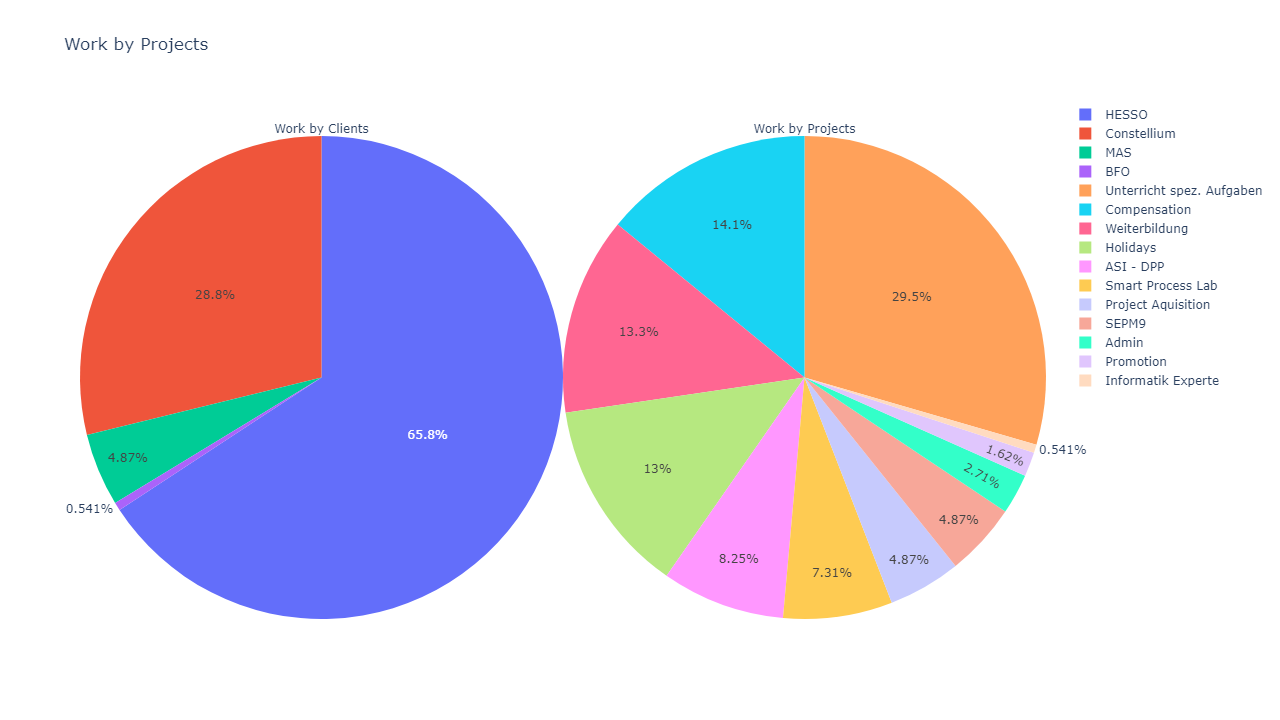

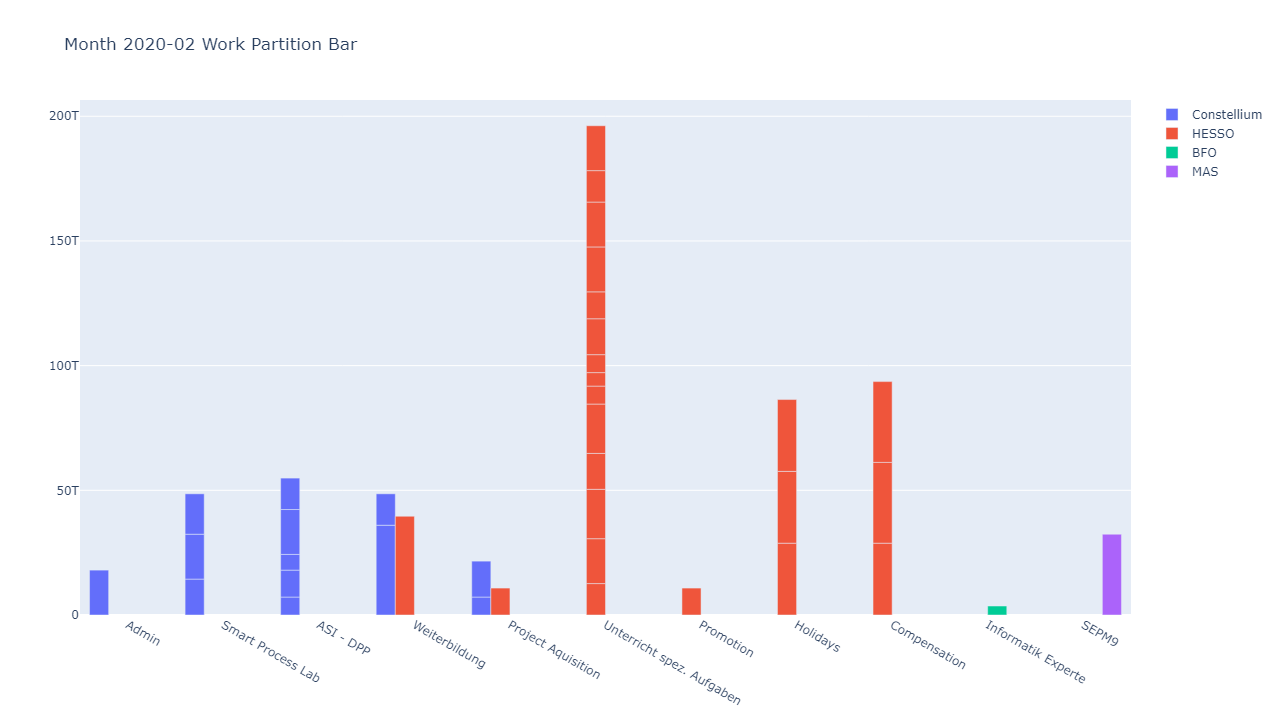

markdown-pdf Month_2020-02_Report.md
  * PDF Report Month_2020-02_Report.pdf generated


In [23]:
if generateMonthlyReport:
    for month in monthReports:
        monthlyreportFilePath = monthlyReport(timeEntriesDf, month)
        generate_report(monthlyreportFilePath, outputDir)

### Weekly

|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             1 |          7 | 
|     project |             2 |          7 | 
| description |             5 |          7 | 
|       start |             7 |          7 | 
|        stop |             7 |          7 | 
|    duration |             3 |          7 | 
## Weekly Working Hours per Clients and Project
Week Number: 12
Timeframe: 16-03-2020 => 22-03-2020
### Client HESSO
| Project | Time |
| ------- | ---- |
| Special Project | 21.0 |
| Unterricht spez. Aufgaben | 10.0 |




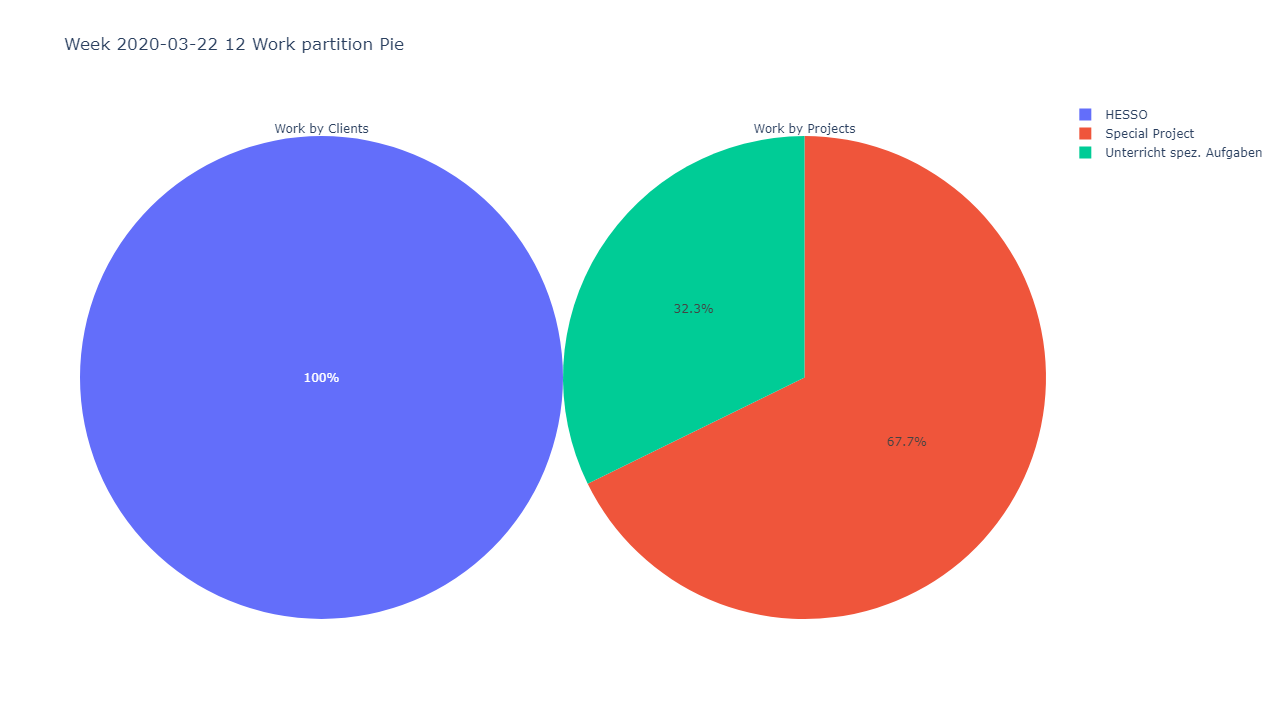

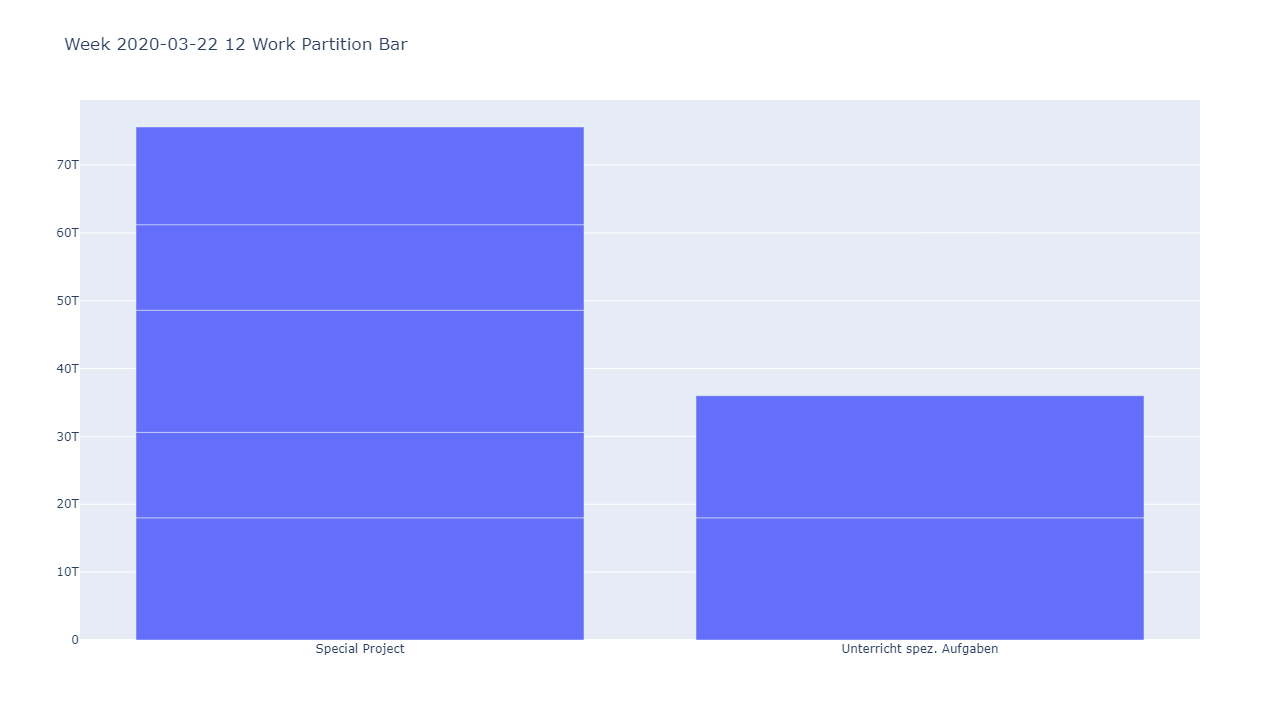

markdown-pdf Week_2020-03-22_12_Report.md
  * PDF Report Week_2020-03-22_12_Report.pdf generated
|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             2 |          9 | 
|     project |             5 |          9 | 
| description |             6 |          9 | 
|       start |             9 |          9 | 
|        stop |             9 |          9 | 
|    duration |             4 |          9 | 
## Weekly Working Hours per Clients and Project
Week Number: 11
Timeframe: 09-03-2020 => 15-03-2020
### Client HESSO
| Project | Time |
| ------- | ---- |
| Admin | 8.5 |
| Compensation | 8.0 |
| P3 Prime | 10.0 |
| Unterricht spez. Aufgaben | 10.0 |


### Client Constellium
| Project | Time |
| ------- | ---- |
| ASI - DPP | 8.0 |




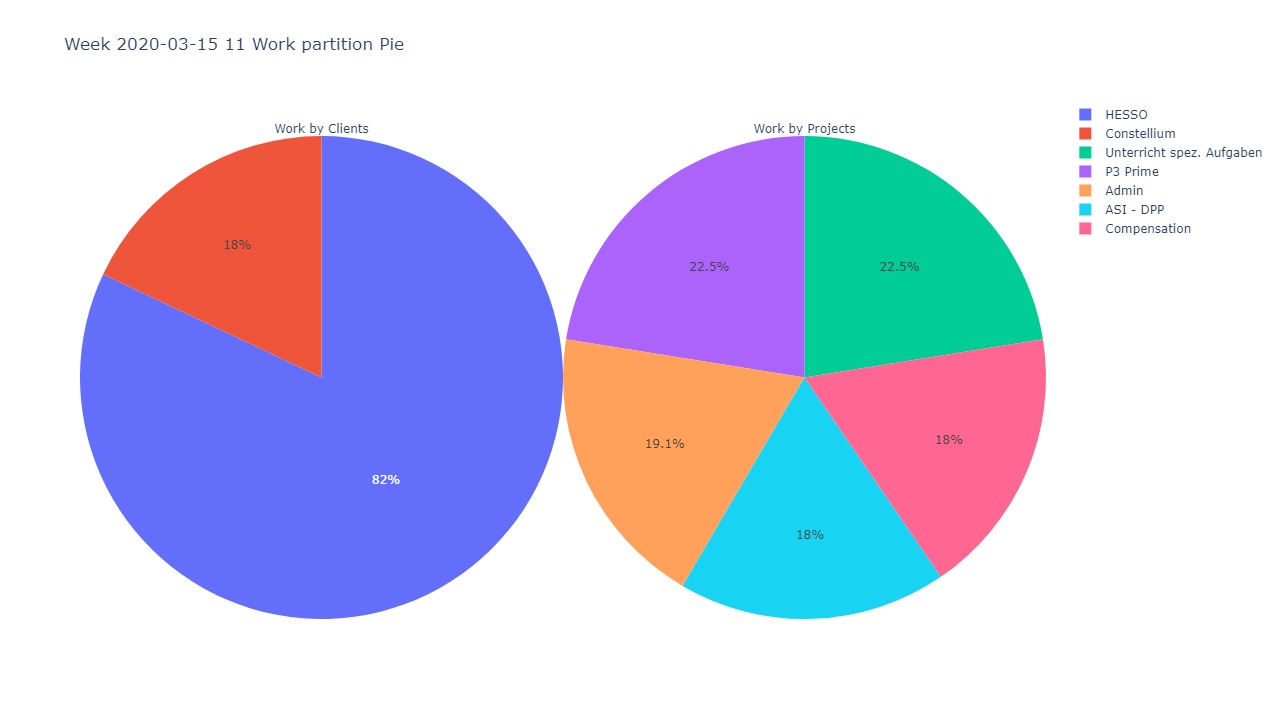

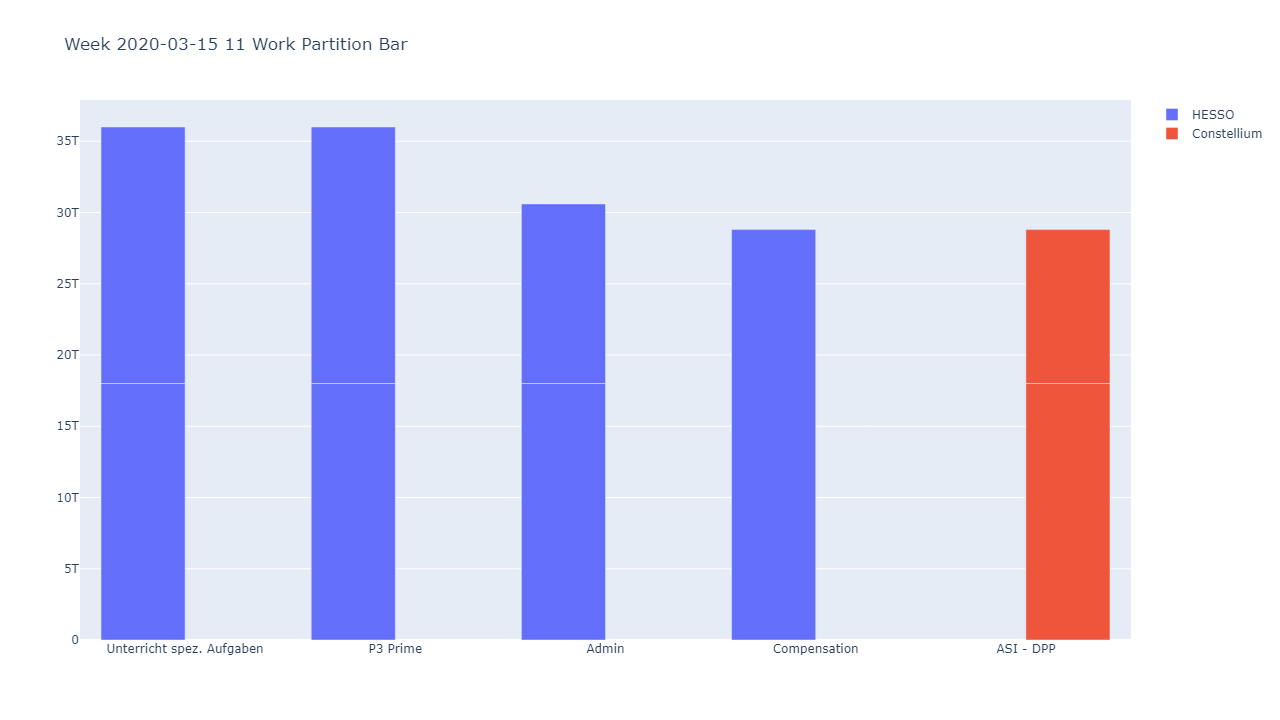

markdown-pdf Week_2020-03-15_11_Report.md
  * PDF Report Week_2020-03-15_11_Report.pdf generated
|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             2 |         12 | 
|     project |             5 |         12 | 
| description |            10 |         12 | 
|       start |            12 |         12 | 
|        stop |            12 |         12 | 
|    duration |             5 |         12 | 
## Weekly Working Hours per Clients and Project
Week Number: 10
Timeframe: 02-03-2020 => 08-03-2020
### Client HESSO
| Project | Time |
| ------- | ---- |
| Compensation | 5.0 |
| Project Aquisition | 3.0 |
| Unterricht spez. Aufgaben | 9.5 |


### Client Constellium
| Project | Time |
| ------- | ---- |
| ASI - DPP | 15.0 |
| Smart Process Lab | 10.0 |




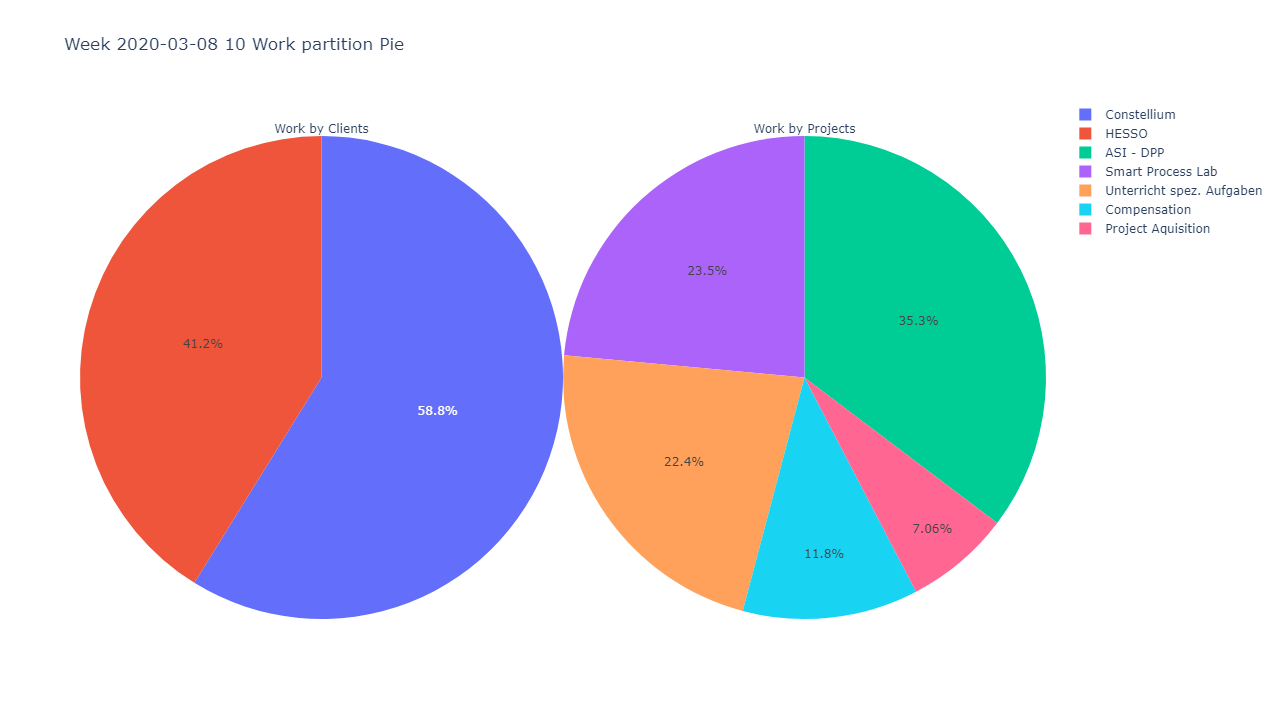

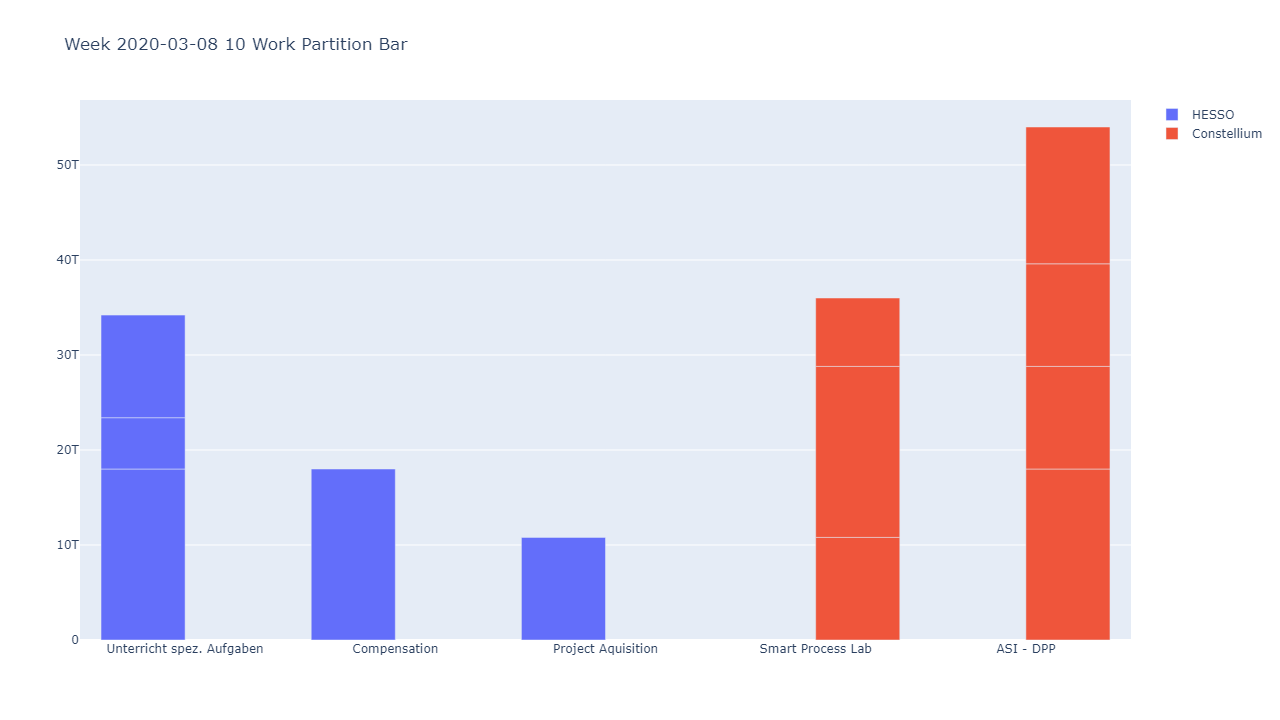

markdown-pdf Week_2020-03-08_10_Report.md
  * PDF Report Week_2020-03-08_10_Report.pdf generated
|   Parameter | Unique Values | Total Rows | 
|-------------|---------------|------------|
|      client |             3 |         10 | 
|     project |             6 |         10 | 
| description |             7 |         10 | 
|       start |            10 |         10 | 
|        stop |            10 |         10 | 
|    duration |             4 |         10 | 
## Weekly Working Hours per Clients and Project
Week Number: 09
Timeframe: 24-02-2020 => 01-03-2020
### Client HESSO
| Project | Time |
| ------- | ---- |
| Compensation | 9.0 |
| Unterricht spez. Aufgaben | 18.5 |


### Client Constellium
| Project | Time |
| ------- | ---- |
| ASI - DPP | 8.5 |
| Smart Process Lab | 4.5 |
| Weiterbildung | 3.5 |


### Client MAS
| Project | Time |
| ------- | ---- |
| SEPM9 | 9.0 |




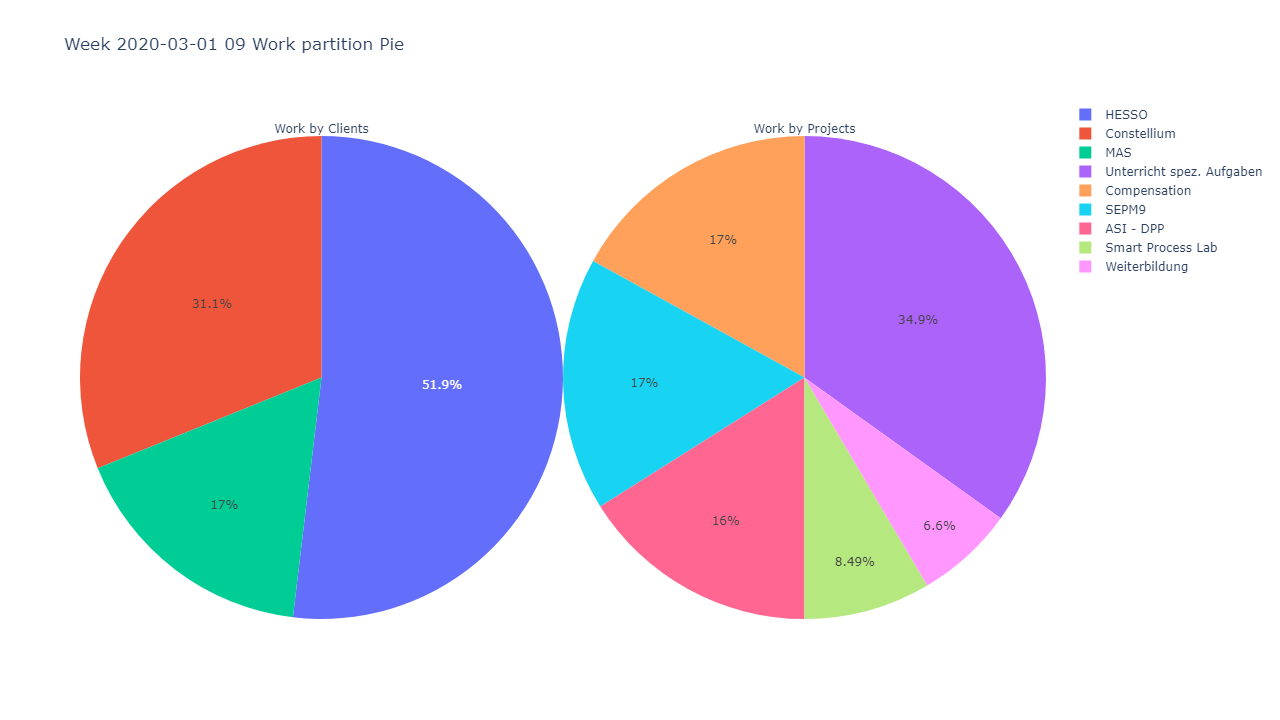

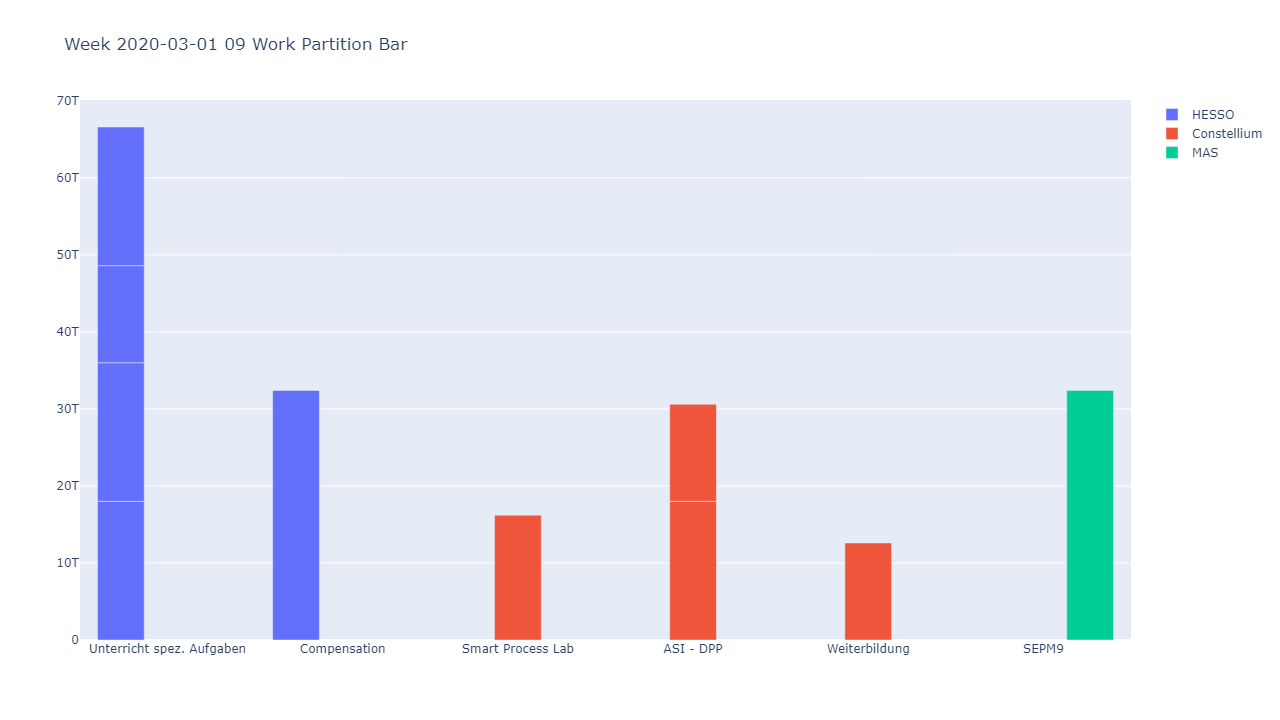

markdown-pdf Week_2020-03-01_09_Report.md
  * PDF Report Week_2020-03-01_09_Report.pdf generated


In [24]:
if generateWeeklyReport:
    for week in weekReports:
        weeklyreportFilePath = weeklyReport(timeEntriesDf, week)
        generate_report(weeklyreportFilePath, outputDir)

## Generate All PDF Reports

In [25]:
if generateAllReports:
    for addMonth in range(0,-5, -1):
        monthlyreportFilePath = monthlyReport(timeEntriesDf, addMonth)
        generate_report(monthlyreportFilePath, outputDir)
        
    for addWeek in range(0,-31, -1):
        weeklyreportFilePath = weeklyReport(timeEntriesDf, addWeek)
        generate_report(weeklyreportFilePath, outputDir)
        
    generate_all_reports(outputDir + md_subdir, outputDir)